In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 1500 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 1500 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":1500, 'savefig.dpi':1500}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
# Tells matplotlib to display images inline instead of a new window
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

from time import time
import timeit #imports timeit module
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

import sklearn.linear_model as skl_lm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [17]:
df = pd.read_csv('../RiverRoad_Quan_RF.csv')
df2 = pd.read_csv('../RR_Quan_2m_dataset.csv')
df2['FID_RiverRd_AOI'] = np.where(df2['NWI_bi']=='wetland', 1, 0)
df2.columns

Index(['GRID_ID', 'dem_MIN', 'dem_MAX', 'dem_RANGE', 'dem_MEAN', 'dem_STD',
       'dem_SUM', 'smdem_MIN', 'smdem_MAX', 'smdem_RANGE', 'smdem_MEAN',
       'smdem_STD', 'smdem_SUM', 'hydem_MIN', 'hydem_MAX', 'hydem_RANGE',
       'hydem_MEAN', 'hydem_STD', 'hydem_SUM', 'dsm_MIN', 'dsm_MAX',
       'dsm_RANGE', 'dsm_MEAN', 'dsm_STD', 'dsm_SUM', 'flowac_MIN',
       'flowac_MAX', 'flowac_RANGE', 'flowac_MEAN', 'flowac_STD', 'flowac_SUM',
       'flowdi_MIN', 'flowdi_MAX', 'flowdi_RANGE', 'flowdi_MEAN', 'flowdi_STD',
       'flowdi_SUM', 'cur_MIN', 'cur_MAX', 'cur_RANGE', 'cur_MEAN', 'cur_STD',
       'cur_SUM', 'curpro_MIN', 'curpro_MAX', 'curpro_RANGE', 'curpro_MEAN',
       'curpro_STD', 'curpro_SUM', 'curpl_MIN', 'curpl_MAX', 'curpl_RANGE',
       'curpl_MEAN', 'curpl_STD', 'curpl_SUM', 'asp_MIN', 'asp_MAX',
       'asp_RANGE', 'asp_MEAN', 'asp_STD', 'asp_SUM', 'ndvi_MIN', 'ndvi_MAX',
       'ndvi_RANGE', 'ndvi_MEAN', 'ndvi_STD', 'ndvi_SUM', 'ndre_MIN',
       'ndre_MAX', 'ndre_RANGE'

In [3]:
def LGBM(X, y, gridid):
    fig, ax = plt.subplots()
    tree_axs = []
    
    start_time = timeit.default_timer()

    kf = KFold(n_splits=5, random_state=2, shuffle=True)
    acc_score = [];
    Truth = [];
    Output = [];
    GRID_ID = pd.DataFrame(columns=['GRID_ID'])

    feature_importances = pd.DataFrame()
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train_index , test_index) in tqdm(enumerate(kf.split(df))):
        X_train , X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index], y.iloc[test_index]
        train_grid = gridid.iloc[train_index]
        test_grid= gridid.iloc[test_index]

        model = LGBMClassifier(n_estimators=500, learning_rate=0.1, max_depth=6 ,random_state=2)

        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)
        
        t_ax = lgb.plot_tree(model, orientation='horizontal')
        tree_axs.append(t_ax)
        
        feature_importance = model.feature_importances_
        rel_imp = pd.DataFrame(feature_importance, index=X_train.columns, columns=[i])
        feature_importances = pd.concat([feature_importances, rel_imp], axis=1)

        viz = plot_roc_curve(model, X_test, y_test,
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)

        GRID_ID = pd.merge(GRID_ID, test_grid, on='GRID_ID', how='outer')
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        Output.extend(pred_values);

    elapsed = timeit.default_timer() - start_time

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="ROC for Light Gradient Boosting Model")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    
    feature_importances['mean'] = feature_importances.iloc[:, 0:5].mean(axis=1)

    output_df = pd.concat([GRID_ID, pd.DataFrame(Truth, columns=["Truth"]), pd.DataFrame(Output, columns=["Output"])], axis=1)
    return output_df, elapsed, confusion_matrix(Truth, Output), classification_report(Truth, Output, digits=4), acc_score, plt, feature_importances['mean'], tree_axs

In [16]:
# Models takes in X for co-variates, y for outcome. gridid is a series with all the gridids
def LGB(X, y, gridid, X2, y2, gridid2):
    # acc_score holds accuracy of all cross-validation iterations. Used to compute mean accuracy
    acc_score = [];
    # contains all truth values for each grid
    Truth = [];
    # contains all output values for each grid
    Output = [];
    # dataframe of grid ids(same as gridid that's passed in)
    GRID_ID = pd.DataFrame(columns=['GRID_ID'])
    # 5 fold Cross-validation
    kf = KFold(n_splits=5, random_state=2, shuffle=True)
    
    # tqdm tracks how many iterations are done(useful for calculating how long processing will take) but not used for anything else
    # train_index and test_index are the indexes of the splits within the cross validation
    for i, (train_index , test_index) in tqdm(enumerate(kf.split(df))):
        # X_train and X_test are the values within the dataframe for the train and test indexes
        X_train , X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        # similar to X_train and y_train
        y_train , y_test = y.iloc[train_index], y.iloc[test_index]
        # Get the grid id of the grid at the train index
        train_grid = gridid.iloc[train_index]
        # get the grid id of the grid at the test index 
        test_grid= gridid.iloc[test_index]
        
        # Assign a model
        model = LGBMClassifier(n_estimators=500, learning_rate=0.1, max_depth=6 ,random_state=2)
 
        # Fit the model to the train and predict the test
        model.fit(X_train, y_train)
    
    pred_values2 = model.predict(X2)
    acc2 = accuracy_score(y2, pred_values2)
    truth2 = []
    truth2.extend(y2.values.reshape(y2.shape[0]))
    output2 = []
    output2.extend(pred_values2)
    conf_mat2 = confusion_matrix(truth2, output2)
    class_rep2 = classification_report(truth2, output2, digits=4)
    ## Return outputs
    return acc2, conf_mat2, class_rep2
 
## Pass in values
X = df.drop(['GRID_ID', 'wetland_type', 'wetland', 'FID_RiverRd_AOI'], axis=1)
y = df.FID_RiverRd_AOI
X2 = df2.drop(['GRID_ID', 'NWI_bi', 'FID_RiverRd_AOI'], axis=1)
y2 = df2.FID_RiverRd_AOI
gridid = df.GRID_ID
gridid2 = df2.GRID_ID
# Run model, get outputs, print outputs
acc_lgb, cm_lgb, cr_lgb = LGB(X, y, gridid, X2, y2, gridid2)
print(acc_lgb)
print(cm_lgb)
print(cr_lgb)

5it [00:10,  2.17s/it]


ValueError: Number of features of the model must match the input. Model n_features_ is 60 and input n_features is 72 

## LGBM with all 60 columns

5it [00:22,  4.47s/it]


22.361859700000423 seconds
[0.9355774811375508, 0.9320557491289199, 0.9262485481997678, 0.9303135888501742, 0.9227642276422764]
0.9293919189917379 accuracy
[[2711  433]
 [ 175 5292]]
              precision    recall  f1-score   support

           0     0.9394    0.8623    0.8992      3144
           1     0.9244    0.9680    0.9457      5467

    accuracy                         0.9294      8611
   macro avg     0.9319    0.9151    0.9224      8611
weighted avg     0.9298    0.9294    0.9287      8611

<module 'matplotlib.pyplot' from 'C:\\Users\\shiti\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>


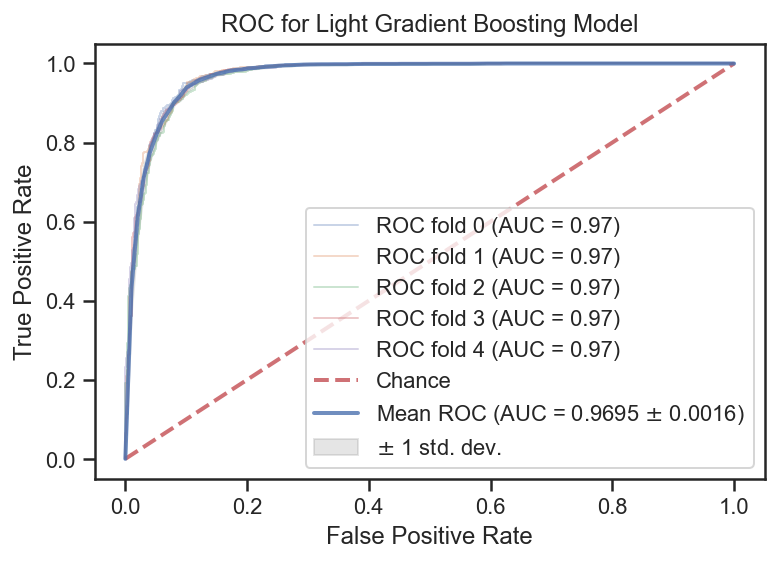

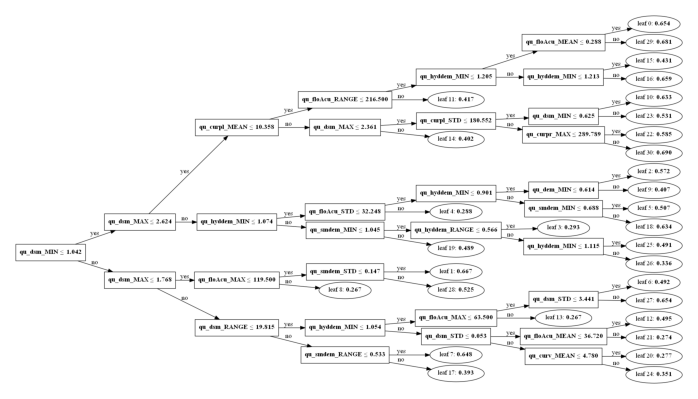

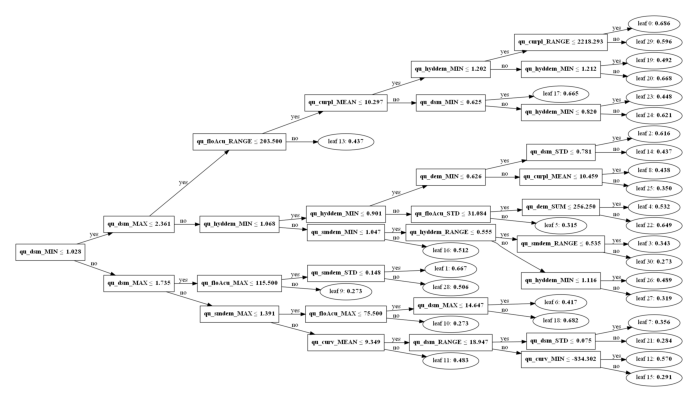

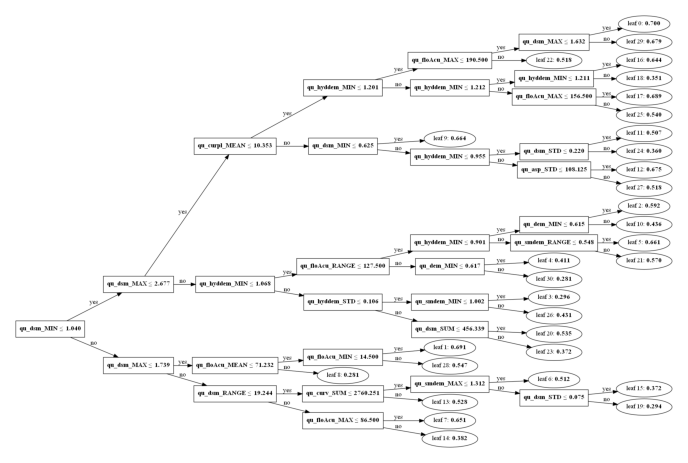

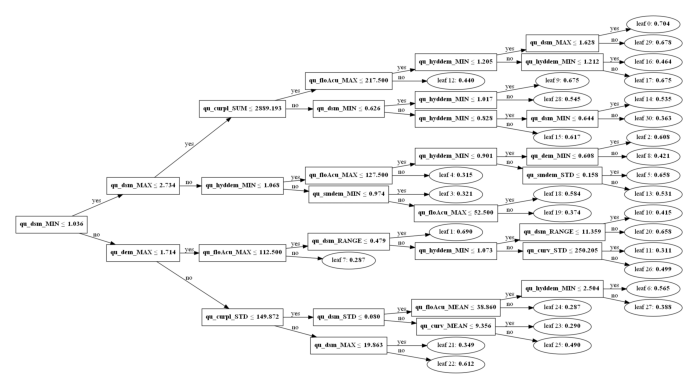

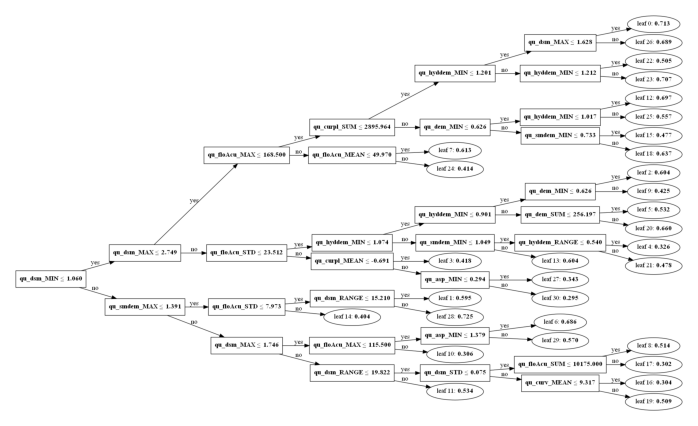

In [7]:
X = df.drop(['GRID_ID', 'wetland_type', 'wetland', 'FID_RiverRd_AOI'], axis=1)
y = df.FID_RiverRd_AOI
gridid = df.GRID_ID
output_df_60, time_60, cm_60, cr_60, acc_60, roc_60, feat_imp_60, tree_axs = LGBM(X, y, gridid)
print(f"{time_60} seconds")
print(f"{acc_60}")
print(f"{np.mean(acc_60)} accuracy")
print(cm_60)
print(cr_60)
print(roc_60)

## LGBM with Asami's 24 columns(Interpretation)

5it [00:08,  1.60s/it]


8.023493000000599 seconds
[0.9408009286128846, 0.9303135888501742, 0.9250871080139372, 0.9279907084785134, 0.9303135888501742]
0.9309011845611368 accuracy
[[2730  414]
 [ 181 5286]]
              precision    recall  f1-score   support

           0     0.9378    0.8683    0.9017      3144
           1     0.9274    0.9669    0.9467      5467

    accuracy                         0.9309      8611
   macro avg     0.9326    0.9176    0.9242      8611
weighted avg     0.9312    0.9309    0.9303      8611

<module 'matplotlib.pyplot' from 'C:\\Users\\shiti\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>


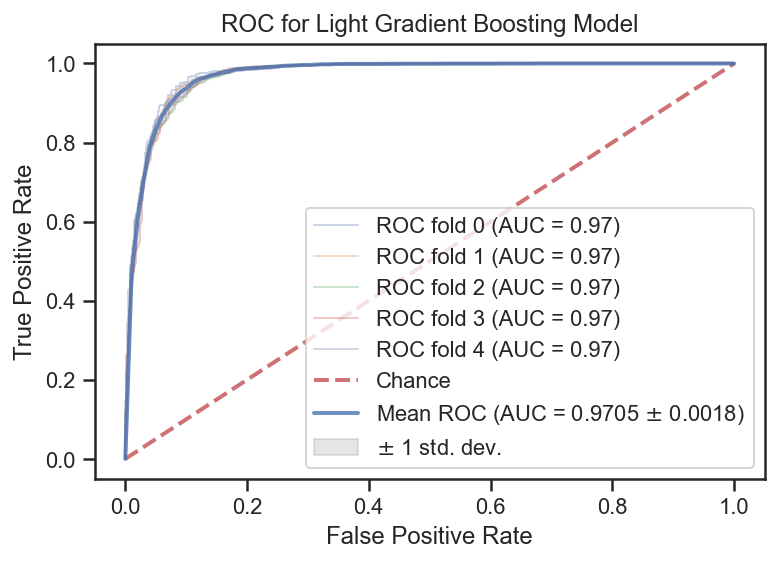

In [74]:
columns = ['qu_dsm_MAX',
'qu_hyddem_MIN',
'qu_dsm_MIN',
'qu_smdem_MAX',
'qu_dem_MIN',
'qu_dsm_SUM',
'qu_dsm_MEAN',
'qu_dsm_RANGE',
'qu_dsm_STD',
'qu_floAcu_MAX',
'qu_floAcu_STD',
'qu_hyddem_MAX',
'qu_dem_MAX',
'qu_floAcu_RANGE',
'qu_curpl_SUM',
'qu_hyddem_SUM',
'qu_curpl_MEAN',
'qu_hyddem_MEAN',
'qu_floAcu_MEAN',
'qu_curpl_STD',
'qu_floAcu_SUM',
'qu_smdem_MIN',
'qu_smdem_SUM',
'qu_curv_STD',
]
X = df[columns]
y = df.FID_RiverRd_AOI
gridid = df.GRID_ID
output_df_24, time_24, cm_24, cr_24, acc_24, roc_24, feat_imp_24 = LGBM(X, y, gridid)
print(f"{time_24} seconds")
print(f"{acc_24}")
print(f"{np.mean(acc_24)} accuracy")
print(cm_24)
print(cr_24)
print(roc)

## LGBM with Asami's 12 columns(Prediction)

5it [00:16,  3.26s/it]


16.647047099999327 seconds
[0.9408009286128846, 0.9256678281068524, 0.9303135888501742, 0.9291521486643438, 0.9262485481997678]
0.9304366084868045 accuracy
[[2735  409]
 [ 190 5277]]
              precision    recall  f1-score   support

           0     0.9350    0.8699    0.9013      3144
           1     0.9281    0.9652    0.9463      5467

    accuracy                         0.9304      8611
   macro avg     0.9316    0.9176    0.9238      8611
weighted avg     0.9306    0.9304    0.9299      8611

<module 'matplotlib.pyplot' from 'C:\\Users\\shiti\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>


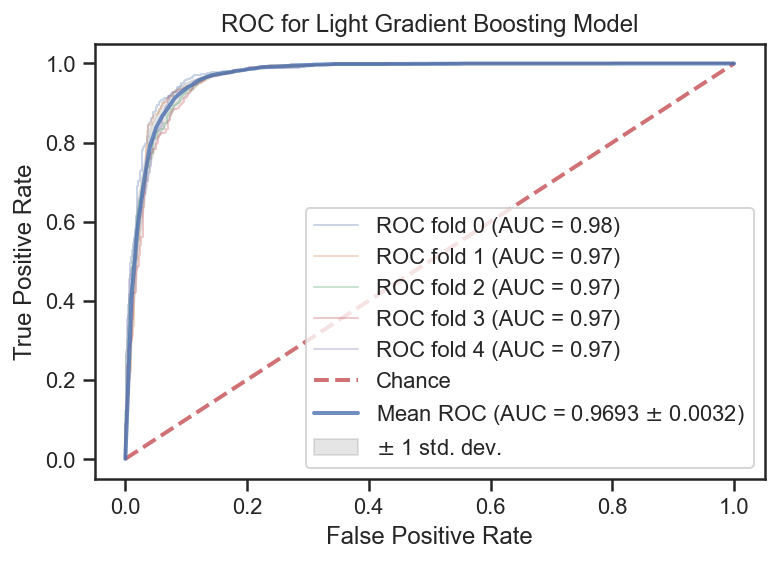

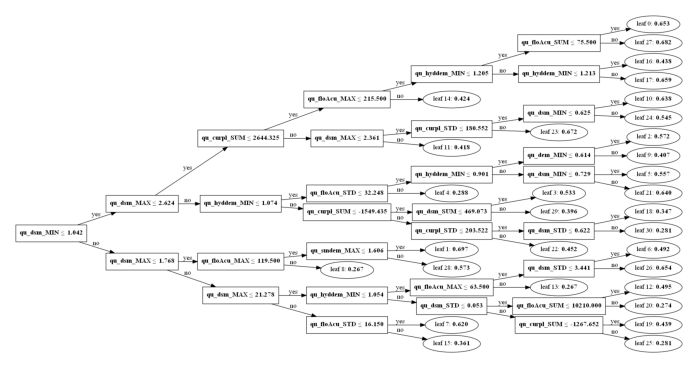

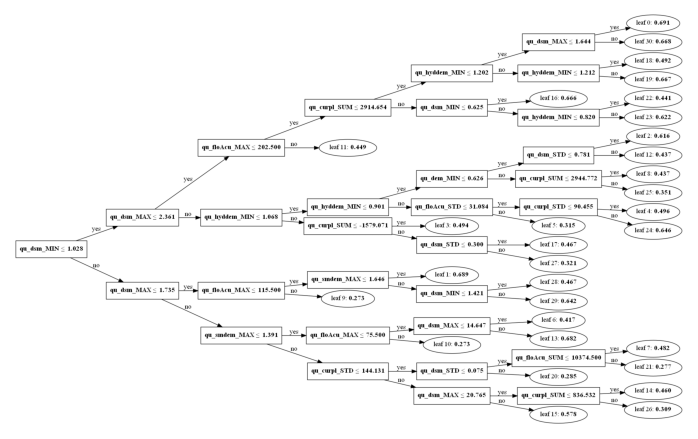

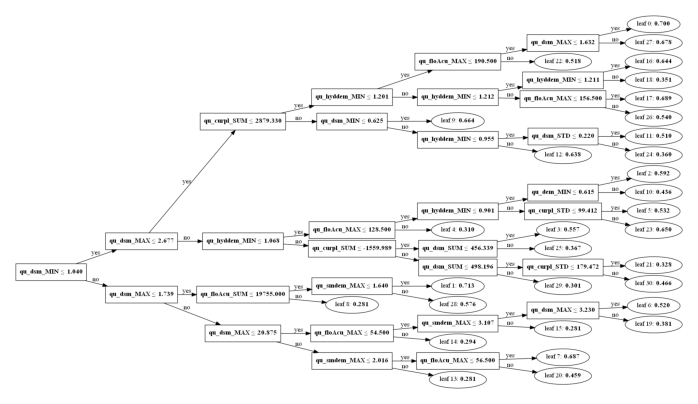

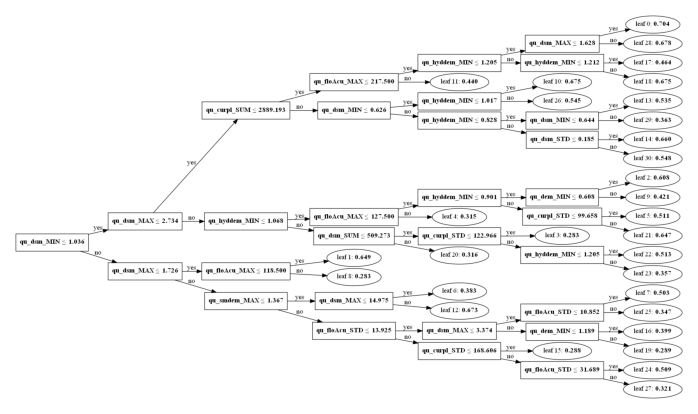

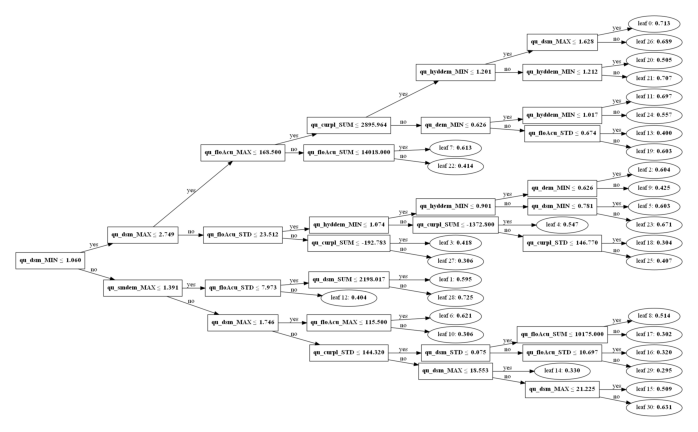

In [36]:
columns = [
'qu_dsm_MAX',
'qu_hyddem_MIN',
'qu_dsm_MIN',
'qu_smdem_MAX',
'qu_dem_MIN',
'qu_dsm_SUM',
'qu_dsm_STD',
'qu_floAcu_MAX',
'qu_floAcu_STD',
'qu_curpl_SUM',
'qu_curpl_STD',
'qu_floAcu_SUM',
]
X = df[columns]
y = df.FID_RiverRd_AOI
gridid = df.GRID_ID
output_df_12, time_12, cm_12, cr_12, acc_12, roc_12, feat_imp_12, tree_axs = LGBM(X, y, gridid)
print(f"{time_12} seconds")
print(f"{acc_12}")
print(f"{np.mean(acc_12)} accuracy")
print(cm_12)
print(cr_12)
print(roc_12)

In [25]:
output_df_60.to_csv("../Comparison Data/LGBM60.csv", index=False)
output_df_24.to_csv("../Comparison Data/LGBM24.csv", index=False)
output_df_12.to_csv("../Comparison Data/LGBM12.csv", index=False)

In [6]:
output_df_60

,GRID_ID,Truth,Output
0,AA-13,0,1
1,AA-14,0,1
2,AA-20,1,1
3,AA-24,1,1
4,AA-29,1,1
...,...,...,...
8606,Z-8,0,0
8607,Z-80,0,0
8608,Z-82,0,0
8609,Z-9,0,0


Text(0.5, 1.0, 'Variable Importance')

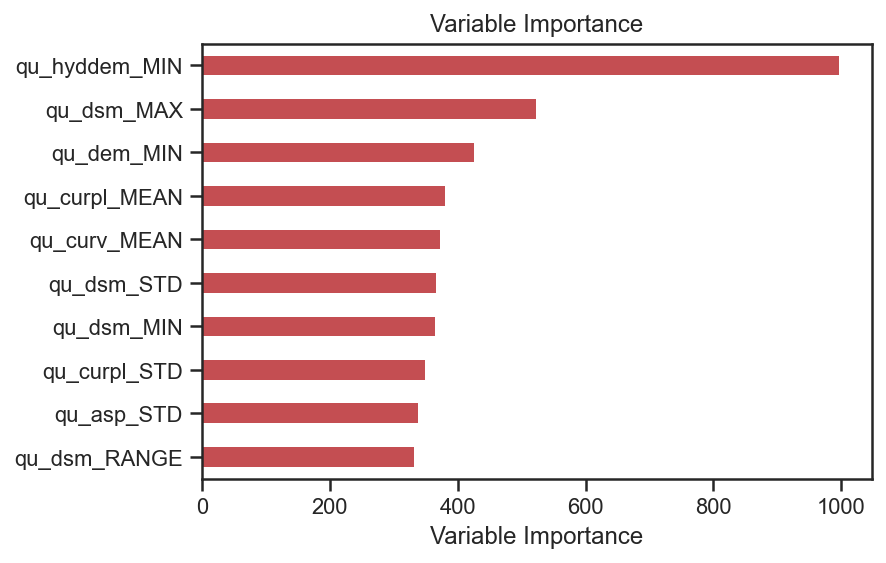

In [51]:
feat_imp_60.sort_values()
fig = feat_imp_60.sort_values()[-10:].T.plot(kind = 'barh', 
               color = 'r')
fig.set_xlabel("Variable Importance")
fig.set_title("Variable Importance")

In [8]:
fig = tree_axs[0].figure
fig.savefig('tree.png')